<a href="https://colab.research.google.com/github/anyuanay/INFO213/blob/main/INFO213_Week5_6_feature_selection_dimensionality_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INFO 213: Data Science Programming 2
___

### Week 5-6:  Feature Selection and Dimensionality Reduction

- [Selecting meaningful features](#Selecting-meaningful-features)
  - [Sequential feature selection algorithms](#Sequential-feature-selection-algorithms)
  - [Assessing feature importance with Random Forests](#Assessing-feature-importance-with-Random-Forests)
- [Unsupervised dimensionality reduction via principal component analysis](#Unsupervised-dimensionality-reduction-via-principal-component-analysis)
  - [The main steps behind principal component analysis](#The-main-steps-behind-principal-component-analysis)
  - [Extracting the principal components step-by-step](#Extracting-the-principal-components-step-by-step)
  - [Total and explained variance](#Total-and-explained-variance)
  - [Feature transformation](#Feature-transformation)
  - [Principal component analysis in scikit-learn](#Principal-component-analysis-in-scikit-learn)
  - [Assessing feature contributions](#Assessing-feature-contributions)
- [Supervised data compression via linear discriminant analysis](#Supervised-data-compression-via-linear-discriminant-analysis) [Optional see chapter 5]
  - [Principal component analysis versus linear discriminant analysis](#Principal-component-analysis-versus-linear-discriminant-analysis)
  - [The inner workings of linear discriminant analysis](#The-inner-workings-of-linear-discriminant-analysis)
  - [Computing the scatter matrices](#Computing-the-scatter-matrices)
  - [Selecting linear discriminants for the new feature subspace](#Selecting-linear-discriminants-for-the-new-feature-subspace)
  - [Projecting examples onto the new feature space](#Projecting-examples-onto-the-new-feature-space)
  - [LDA via scikit-learn](#LDA-via-scikit-learn)
- [Nonlinear dimensionality reduction techniques](#Nonlinear-dimensionality-reduction-techniques) [Optional see chapter 5]
  - [Visualizing data via t-distributed stochastic neighbor embedding](#Visualizing-data-via-t-distributed-stochastic-neighbor-embedding)

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image

# Load Data
The wine data set:
- The data is the results of a chemical analysis of wines grown in the same region in Italy by three different cultivators. There are thirteen different measurements taken for different constituents found in the three types of wine.

In [2]:
# load the wine data from scikit learn data sets
from sklearn.datasets import load_wine

data = load_wine(as_frame=True)

df_wine = data.frame

In [3]:
# rename the column names
df_wine.columns = ['Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline', 'Class_label']

print('Class labels', np.unique(df_wine['Class_label']))

Class labels [0 1 2]


In [4]:
df_wine.shape

(178, 14)

# Split the data into trainning and test set

In [5]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, :-1].values, df_wine.iloc[:, -1].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y,
                     test_size=0.3,
                     random_state=0,
                     stratify=y)

In [6]:
X.shape, y.shape

((178, 13), (178,))

# Bringing features onto the same scale

In [7]:
# Min-max scaler
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

In [8]:
# Standard scaler
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

# Select meaningful features

- While regularization (L2 or L1) is an approach for addressing overfitting, an alternative way to reduce model complexity is dimensionality reduction.
- There are two main categories of dimensionality reduction techniques: feature selection and feature extraction.
- Via feature selection, we select a subset of the original features, whereas in feature extraction, we derive
information from the feature set to construct a new feature subspace.

## Sequential feature selection algorithms

- Sequential feature selection algorithms are a family of greedy search algorithms that are used to
reduce an initial d-dimensional feature space to a k-dimensional feature subspace where $k<d$.

- Let $J$ be the criterion that measures the classification performance before and after the removal of a particular feature.
- We eliminate the feature that causes the least performance loss after removal.
- The sequential backward selection (SBS) algorithm is outlined as follows:
 1. Initialize the algorithm with $k = d$, where $d$ is the dimensionality of the full feature space, $X_d$.
 2. Determine the feature, $\bar{x}$, that maximizes the criterion:$\bar{x}$ = argmax $J(X_k – x)$, where $x\in X_k$.
 3. Remove the feature, $\bar{x}$, from the feature set: $X_{k–1} = X_k – \bar{x}; k = k – 1$.
 4. Terminate if k equals the number of desired features; otherwise, go to step 2.

# KNN classifier:
- Instance-based learning algorithm, It doesn't build an explicit model but stores the training data.

- A new data point is classified by a majority vote of its k nearest neighbors in the training dataset.

- Commonly uses Euclidean distance (but others like Manhattan, Minkowski, or cosine similarity can be used).

- Small k → more sensitive to noise.

- Large k → more stable but may include distant or irrelevant neighbors.

- Feature scaling is important: KNN is sensitive to the scale of the features, so normalization/standardization is often necessary.

- Curse of dimensionality: Performance can degrade in high-dimensional spaces due to sparse data.

- Works well for small datasets: Not suitable for large datasets because of high computation cost during prediction.

In [20]:
from sklearn.neighbors import KNeighborsClassifier

## Use Scikit Learn SequentialFeatureSelector and KNN Classifier

In [10]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_selection import SequentialFeatureSelector

In [11]:
knn = KNeighborsClassifier(n_neighbors=5)

In [12]:
sfs = SequentialFeatureSelector(knn, n_features_to_select=6)

In [13]:
sfs.fit(X_train_std, y_train)

SequentialFeatureSelector(estimator=KNeighborsClassifier(),
                          n_features_to_select=6)

In [14]:
sfs.support_

array([ True, False, False, False,  True, False,  True, False, False,
        True,  True, False,  True])

In [15]:
# selected features
selected_columns = df_wine.columns[:-1][sfs.support_]
selected_columns

Index(['Alcohol', 'Magnesium', 'Flavanoids', 'Color intensity', 'Hue',
       'Proline'],
      dtype='object')

In [16]:
from sklearn.metrics import accuracy_score

In [17]:
# Accuracy before feature selection
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train_std, y_train)

y_pred = knn.predict(X_test_std)

accuracy_score(y_test, y_pred)

0.9629629629629629

In [18]:
# Accuracy after feature selection
knn = KNeighborsClassifier(n_neighbors=5)

X_train_std_selected = X_train_std[:, sfs.support_]
X_train_std.shape, X_train_std_selected.shape

((124, 13), (124, 6))

In [19]:
knn.fit(X_train_std_selected, y_train)

y_pred = knn.predict(X_test_std[:, sfs.support_])

accuracy_score(y_test, y_pred)

0.9814814814814815

- As we can see the accuracy of the KNN classifier improved on the validation dataset as we reduced the number of features.
- It is likely due to a decrease in the curse of dimensionality.
- What is the curse of dimensionality?
 - It referes to data in high-dimensional spaces.
 - As the number of features (dimensions) increases, the volume of the space increases so fast that the available data becomes sparse.
 - This sparsity makes it difficult for algorithms like K-Nearest Neighbors (KNN) to find meaningful neighbors, because all data points tend to become equally far apart.
 - Models may overfit, learning noise rather than signal.

# Retrieval Practice

# Decision Tree and Random Forest

## Decision Tree
- Decision tree classifiers are attractive models if we care about interpretability.
- Decision tree breaks down our data by making a decision based on asking a series of questions.
- Decision tree is not senstive to feature scale.


<img src="https://github.com/rasbt/machine-learning-book/blob/main/ch03/figures/03_17.png?raw=true" width="500" />

In [21]:
from sklearn.tree import DecisionTreeClassifier

# decision tree hyperparameters
dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=2, min_samples_split=2)

In [22]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [23]:
y_pred = dt.predict(X_test)

In [24]:
accuracy_score(y_test, y_pred)

0.8518518518518519

## Random Forest:
- Random forest can be considerednas an ensemble of decision trees.
- The idea behind a random forest is to average multiple (deep) decision trees that individually suffer from high variance to build a more robust model that has a better generalization performance and is less susceptible to overfitting.
- The random forest algorithm can be summarized in four simple steps:
 1. Draw a random bootstrap sample of size n (randomly choose n examples from the training  dataset with replacement).
 2. Grow a decision tree from the bootstrap sample. At each node:
   - a. Randomly select d features without replacement.
   - b. Split the node using the feature that provides the best split according to the objective function, for instance, maximizing the information gain.
 3. Repeat steps 1-2 k times.
 4. Aggregate the prediction by each tree to assign the class label by majority vote.

In [26]:
from sklearn.ensemble import RandomForestClassifier

# random forest hyperparameters
rf = RandomForestClassifier(n_estimators=25, random_state=1, n_jobs=2)

In [27]:
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=25, n_jobs=2, random_state=1)

In [28]:
y_pred = rf.predict(X_test)

In [29]:
accuracy_score(y_test, y_pred)

1.0

# Assessing feature importance with Random Forests

- Another useful approach for selecting relevant features from a dataset is using a random forest, an ensemble
technique of decision trees.
- Using a random forest, we can measure the feature
importance as the averaged impurity decrease computed from all decision trees in the forest, without
making any assumptions about whether our data is linearly separable or not.
- Conveniently, the random
forest implementation in scikit-learn already collects the feature importance values for us so that we
can access them via the feature_importances_ attribute after fitting a RandomForestClassifier.

In [31]:
feat_labels = df_wine.columns[:-1]
feat_labels

Index(['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium',
       'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
       'Proanthocyanins', 'Color intensity', 'Hue',
       'OD280/OD315 of diluted wines', 'Proline'],
      dtype='object')

In [33]:
forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=1)

In [34]:
importances = forest.feature_importances_
importances

array([0.11852942, 0.02564836, 0.01327854, 0.02236594, 0.03135708,
       0.05087243, 0.17475098, 0.01335393, 0.02556988, 0.1439199 ,
       0.058739  , 0.13616194, 0.1854526 ])

In [36]:
indices = np.argsort(importances)[::-1]
indices

array([12,  6,  9, 11,  0, 10,  5,  4,  1,  8,  3,  7,  2])

In [37]:
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[indices[f]],
                            importances[indices[f]]))

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
 6) Hue                            0.058739
 7) Total phenols                  0.050872
 8) Magnesium                      0.031357
 9) Malic acid                     0.025648
10) Proanthocyanins                0.025570
11) Alcalinity of ash              0.022366
12) Nonflavanoid phenols           0.013354
13) Ash                            0.013279


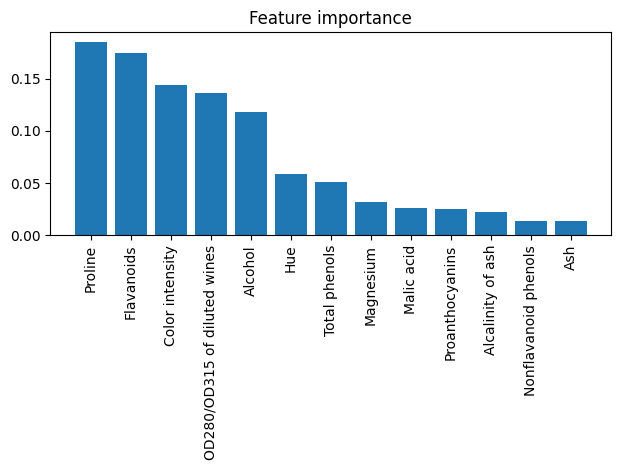

In [40]:
plt.title('Feature importance')
plt.bar(range(X_train.shape[1]),
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]),
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
# plt.savefig('figures/04_10.png', dpi=300)
plt.show()

## SelectFromModel from Scikit Learn
- Scikit-Learn also implements a SelectFromModel object that selects features based on a user-specified
threshold after model fitting.
- It is useful if we want to use the RandomForestClassifier as
a feature selector and intermediate step in a scikit-learn Pipeline object.
- For example, we could set the threshold of feature importance to 0.1 to reduce the dataset to the five most important features using the following code:

In [43]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
X_selected = sfm.transform(X_train)
print('Number of features that meet this threshold criterion:',
      X_selected.shape[1])

Number of features that meet this threshold criterion: 5


Now, let's print the 3 features that met the threshold criterion for feature selection that we set earlier (note that this code snippet does not appear in the actual book but was added to this notebook later for illustrative purposes):

In [42]:
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[indices[f]],
                            importances[indices[f]]))

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529


# Retrieval Practice

# Unsupervised dimensionality reduction via principal component analysis

- Similar to feature selection, we can use different feature extraction techniques to reduce the number
of features in a dataset.
- The difference between feature selection and feature extraction is that while
we maintain the original features when we use feature selection algorithms, such as sequential backward
selection, we use feature extraction to transform or project the data onto a new feature space.
- In the context of dimensionality reduction, feature extraction can be understood as an approach to
data compression with the goal of maintaining most of the relevant information.
- In practice, feature
extraction is not only used to improve storage space or the computational efficiency of the learning
algorithm but can also improve the predictive performance by reducing the curse of dimensionality.

## Principal Component Analysis (PCA)
- Principal component analysis (PCA) is an unsupervised linear transformation technique that is widely used across different fields.
- Other popular applications of PCA include exploratory data analysis and the denoising of signals in stock market trading, and the analysis of genome data and gene expression
levels in the field of bioinformatics.

## Purpose of PCA
- PCA helps us to identify patterns in data based on the correlation between features.
- In a nutshell, PCA aims to find the directions of maximum variance in high-dimensional data and projects the data onto
a new subspace with equal or fewer dimensions than the original one.
- The orthogonal axes (principal components) of the new subspace can be interpreted as the directions of maximum variance given
the constraint that the new feature axes are orthogonal to each other.

<img src="https://github.com/rasbt/machine-learning-book/blob/main/ch05/figures/05_01.png?raw=true" width="500"/>


### PCA Transformation
- If we use PCA for dimensionality reduction, we construct a $d×k$-dimensional transformation matrix,
$\mathbf{W}$, that allows us to map a vector of the features of the training example, $\mathbf{x}$, onto a new $k$-dimensional
feature subspace that has fewer dimensions than the original $d$-dimensional feature space.
- For instance, the process is as follows.
 - Suppose we have a feature vector, $\mathbf{x}$:
 $$
 \mathbf{x}= [x_1, x_2, ..., x_d], \mathbf{x}\in \mathbb{R}^d
 $$
 - which is then transformed by a transformation matrix, $\mathbf{W}\in \mathbb{R}^{dxk}$:
 $$
  \mathbf{x} \mathbf{W} = \mathbf{z}
 $$
 - resulting in the output vector: $\mathbf{z}\in \mathbb{R}^k$, where $k<<d$.

### Steps for Principle Component Analysis (PCA)

- PCA is high sensitive to feature scale and and we need to standardize the features prior to PCA.
- The steps for PCA are summarized as below:
 1. Standardize the $d$-dimensional dataset.
 2. Construct the covariance matrix.
 3. Decompose the covariance matrix into its eigenvectors and eigenvalues.
 4. Sort the eigenvalues by decreasing order to rank the corresponding eigenvectors.
 5. Select $k$ eigenvectors, which correspond to the $k$ largest eigenvalues, where $k$ is the dimensionality of the new feature subspace ($k\leq d$).
 6. Construct a projection matrix, $\mathbf{W}$, from the “top” $k$ eigenvectors.
 7. Transform the $d$-dimensional input dataset, $\mathbf{X}$, using the projection matrix, $\mathbf{W}$, to obtain the new $k$-dimensional feature subspace.

## Extracting the principal components step-by-step

#### Step 1: Load the wine data, split into training and tet set, and standardize the features

- Run the data loading and pre-processing cells at the beginnig of this notebook.



#### Step 2: Construct the covariance matrix.

- The symmetric $d×d$-dimensional covariance matrix,
where $d$ is the number of dimensions in the dataset, stores the pairwise covariances between the different
features.
- For example, the covariance between two features, $x_j$ and $x_k$, on the population level
can be calculated via the following equation:
$$
\sigma_{jk} = \frac{1}{n-1}\sum_{1}^{n}(x^{(i)}_j-\mu_j)(x^{(i)}_k-\mu_k)
$$
Here, $\mu_j$ and $\mu_k$ are the sample means of features $j$ and $k$, respectively.

In [47]:
cov_mat = np.cov(X_train_std.T)

#### Step 3: Decompose the covariance matrix into its eigenvectors and eigenvalues.
- Eigenvectors and eigenvalues of a matrix $\Sigma$:
$$
\Sigma \mathbf{v} = \lambda \mathbf{v}
$$
- We will use the linalg.eig function from NumPy to obtain
the eigenpairs of the Wine covariance matrix:

In [50]:
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\nEigenvalues \n', eigen_vals)


Eigenvalues 
 [4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


<br>
<br>

#### Step 4: Sort the eigenvalues by decreasing order to rank the corresponding eigenvectors.

- Since we want to reduce the dimensionality of our dataset by compressing it onto a new feature subspace, we only select the subset of the eigenvectors (principal components) that contains most of the information (variance).
- The eigenvalues define the magnitude of the eigenvectors, so we have to sort the eigenvalues by decreasing magnitude.
- We are interested in the top k eigenvectors based on the values
of their corresponding eigenvalues.
- Let us plot the variance explained ratios of the eigenvalue, the fraction of an eigenvalue, $\lambda_j$, and the total sum of the eigenvalues:
$$
explained\_variance\_ratio =\frac{\lambda_j}{\sum_{j=1}^{d} \lambda_j}
$$

In [51]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

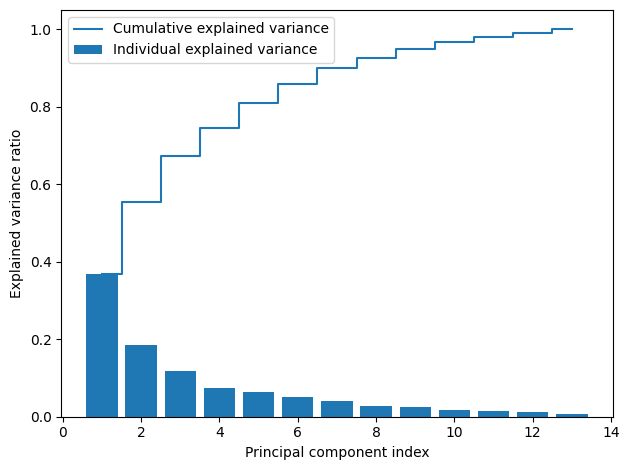

In [52]:
import matplotlib.pyplot as plt


plt.bar(range(1, 14), var_exp, align='center',
        label='Individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('figures/05_02.png', dpi=300)
plt.show()

<br>
<br>

In [53]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [54]:
eigen_pairs

[(np.float64(4.8427453156558915),
  array([-0.13724218,  0.24724326, -0.02545159,  0.20694508, -0.15436582,
         -0.39376952, -0.41735106,  0.30572896, -0.30668347,  0.07554066,
         -0.32613263, -0.36861022, -0.29669651])),
 (np.float64(2.4160245870352246),
  array([ 0.50303478,  0.16487119,  0.24456476, -0.11352904,  0.28974518,
          0.05080104, -0.02287338,  0.09048885,  0.00835233,  0.54977581,
         -0.20716433, -0.24902536,  0.38022942])),
 (np.float64(1.5484582488203518),
  array([-0.13774873,  0.09615039,  0.67777567,  0.62504055,  0.19613548,
          0.14031057,  0.11705386,  0.13121778,  0.0304309 , -0.07992997,
          0.05305915,  0.13239103, -0.07065022])),
 (np.float64(0.9612043774977352),
  array([-0.0032961 ,  0.56264669, -0.10897711,  0.0338187 , -0.36751107,
          0.24024513,  0.1870533 , -0.02292622,  0.49626233,  0.10648294,
         -0.36905375,  0.14201609, -0.16768217])),
 (np.float64(0.8416616104578422),
  array([-0.29062523,  0.08953787,

#### Step 5: Select $k$ eigenvectors, which correspond to the $k$ largest eigenvalues, where $k$ is the dimensionality of the new feature subspace ($k\leq d$).

- We collect the 2 eigenvectors that correspond to the 2 largest eigenvalues, to capture about
60 percent of the variance in this dataset.
- Note that two eigenvectors have been chosen for the purpose
of illustration, since we are going to plot the data via a two-dimensional scatterplot later in this subsection.
- In practice, the number of principal components has to be determined by a tradeoff between computational efficiency and the performance of the classifier:

In [61]:
eigen_pairs[0][1][:, np.newaxis]

array([[-0.13724218],
       [ 0.24724326],
       [-0.02545159],
       [ 0.20694508],
       [-0.15436582],
       [-0.39376952],
       [-0.41735106],
       [ 0.30572896],
       [-0.30668347],
       [ 0.07554066],
       [-0.32613263],
       [-0.36861022],
       [-0.29669651]])

In [63]:
eigen_pairs[1][1][:, np.newaxis]

array([[ 0.50303478],
       [ 0.16487119],
       [ 0.24456476],
       [-0.11352904],
       [ 0.28974518],
       [ 0.05080104],
       [-0.02287338],
       [ 0.09048885],
       [ 0.00835233],
       [ 0.54977581],
       [-0.20716433],
       [-0.24902536],
       [ 0.38022942]])

#### Step 6: Construct a projection matrix, $\mathbf{W}$, from the “top” $k$ eigenvectors.

In [62]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


**Note**
Depending on which version of NumPy and LAPACK you are using, you may obtain the Matrix W with its signs flipped. Please note that this is not an issue: If $v$ is an eigenvector of a matrix $\Sigma$, we have

$$\Sigma v = \lambda v,$$

where $\lambda$ is our eigenvalue,


then $-v$ is also an eigenvector that has the same eigenvalue, since
$$\Sigma \cdot (-v) = -\Sigma v = -\lambda v = \lambda \cdot (-v).$$

#### Step 7: Transform the $d$-dimensional input dataset, $\mathbf{X}$, using the projection matrix, $\mathbf{W}$, to obtain the new $k$-dimensional feature subspace.

- Using the projection matrix, we can now transform an example, $x$ (represented as a 13-dimensional
row vector), onto the PCA subspace (the principal components one and two) obtaining $x′$
- Now a two-dimensional example vector consisting of two new features: $\mathbf{x}′ = \mathbf{x} \mathbf{W}$

In [68]:
# an example vector
x = X_train_std[0]

x_prime = x.dot(w)

x_prime

array([2.38299011, 0.45458499])

#### Visualization
- Lastly, let’s visualize the transformed Wine training dataset, now stored as an 124×2-dimensional matrix, in a two-dimensional scatterplot:

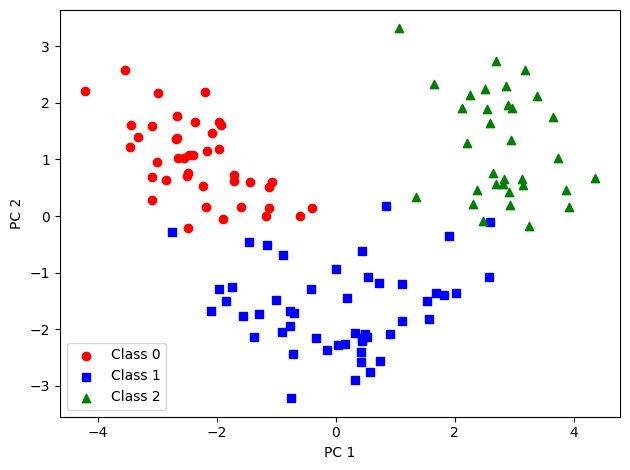

In [71]:
# dimensionality reduction from 13 to 2
X_train_pca = X_train_std.dot(w)

colors = ['r', 'b', 'g']
markers = ['o', 's', '^']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0],
                X_train_pca[y_train == l, 1],
                c=c, label=f'Class {l}', marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()

plt.show()

# Retrieval Practice

## Principal component analysis in scikit-learn

- The PCA class is another one of scikit-learn’s transformer classes.
- Let’s use the PCA class from scikit-learn on the Wine training dataset, classify the transformed examples via logistic regression, and visualize the decision regions via the
plot_decision_regions function.

In [73]:
from sklearn.decomposition import PCA

In [72]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')

#### Transform the trainning and test data into 2 features
- fit the PCA on the training set and transform the training and test set using the same PCA

In [74]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

#### Training logistic regression classifier using the first 2 principal components.

In [76]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=1, solver='lbfgs')
lr = lr.fit(X_train_pca, y_train)

#### Visualize the decision boundary for training data

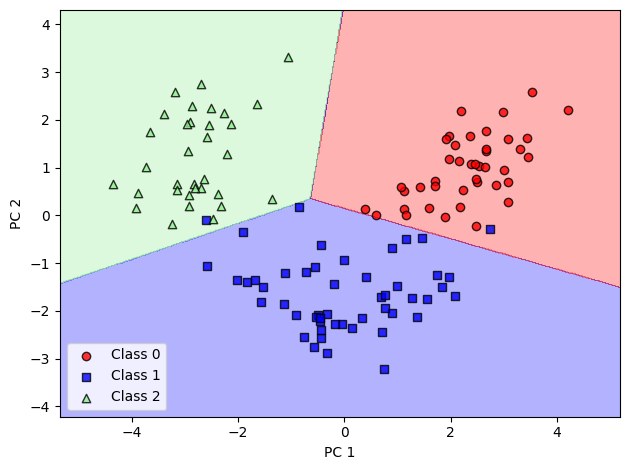

In [77]:
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()

plt.show()

#### Visualize the decision boundary for the test data
For the sake of completeness, let’s plot the decision regions of the logistic regression on the transformed test dataset to see if it can separate the classes well:


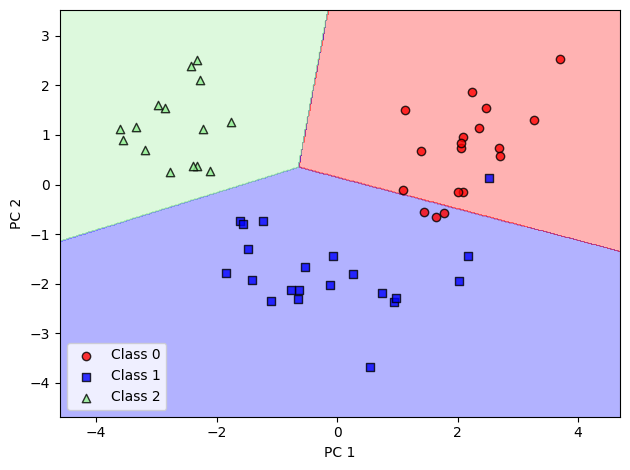

In [78]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('figures/05_05.png', dpi=300)
plt.show()

#### Access the explained variance

- If we are interested in the explained variance ratios of the different principal components, we can
simply initialize the PCA class with the n_components parameter set to None.
- All principal components are kept and the explained variance ratio can then be accessed via the explained_variance_ratio_
attribute:

In [79]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

## Assessing feature contributions

- As we learned, via PCA, we create principal components that represent linear combinations of the features.
- Sometimes, we are interested to know about how much each original feature contributes to a given principal component.
- These contributions are often called loadings.
- The factor loadings can be computed by scaling the eigenvectors by the square root of the eigenvalues.
- The resulting values can then be interpreted as the correlation between the original features and
the principal component.
- To illustrate this, let us plot the loadings for the first principal component.
- First, we compute the 13×13-dimensional loadings matrix by multiplying the eigenvectors by the square root of the eigenvalues:

In [81]:
loadings = eigen_vecs * np.sqrt(eigen_vals)
loadings[:, 0]

array([-0.3020184 ,  0.54408942, -0.05600938,  0.45540829, -0.33970111,
       -0.8665386 , -0.9184327 ,  0.67279444, -0.67489496,  0.16623657,
       -0.71769524, -0.81117245, -0.65291742])

Then, we plot the loadings for the first principal component, loadings[:, 0], which is the first column
in this matrix:

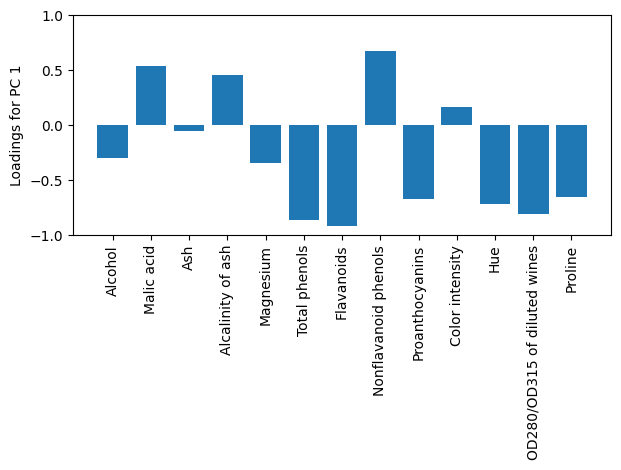

In [83]:
fig, ax = plt.subplots()

ax.bar(range(13), loadings[:, 0], align='center')
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[:-1], rotation=90)

plt.ylim([-1, 1])
plt.tight_layout()

plt.show()

- We can see that, for example, Alcohol has a negative correlation with the first principal
component (approximately –0.3), whereas Malic acid has a positive correlation (approximately 0.54).
Note that a value of 1 describes a perfect positive correlation whereas a value of –1 corresponds to a
perfect negative correlation:

### Access the feature contributions for Scikit-Learn PCA
- In the preceding code example, we compute the factor loadings for our own PCA implementation.
- We can obtain the loadings from a fitted scikit-learn PCA object in a similar manner, where `pca.components_` represents the eigenvectors and `pca.explained_variance_` represents the eigenvalues:

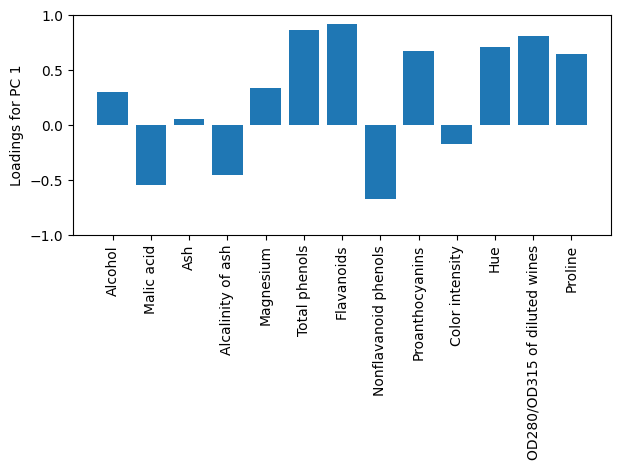

In [85]:
sklearn_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig, ax = plt.subplots()

ax.bar(range(13), sklearn_loadings[:, 0], align='center')
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[:-1], rotation=90)

plt.ylim([-1, 1])
plt.tight_layout()

plt.show()

# Retrieval Practice